In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [2]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return g_value

In [3]:
def generate_D1(n, a,b,c,d, l, u):
    ys = np.random.uniform(l,u,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, l, u, sigma=0.01, plot=True):
    ys = np.random.uniform(l,u,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [4]:
a = 0.1
b = 4
c = 2
d = 0
sigma = 0.01

l = 1e-5
u = 1- 1e-5

In [5]:
# a = 1
# b = 4
# c = 0
# d = 1

No handles with labels found to put in legend.


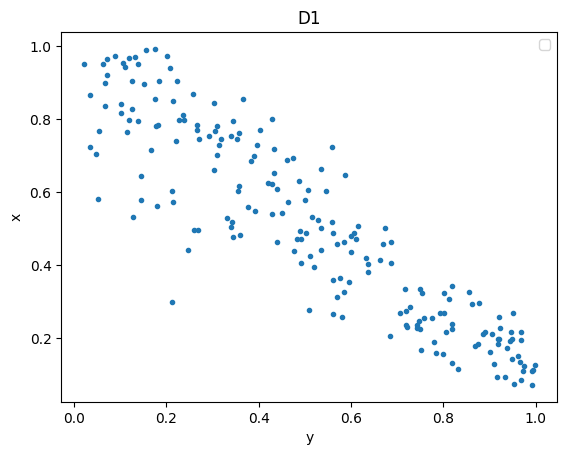

In [6]:
xs, ys = generate_D1(200,a,b,c,d, l, u)

Text(0, 0.5, 'f(x)')

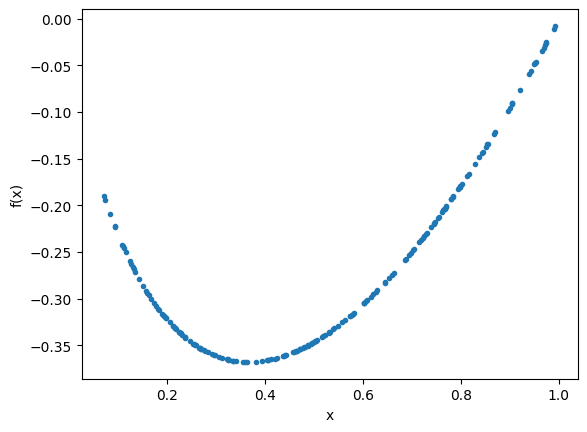

In [7]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

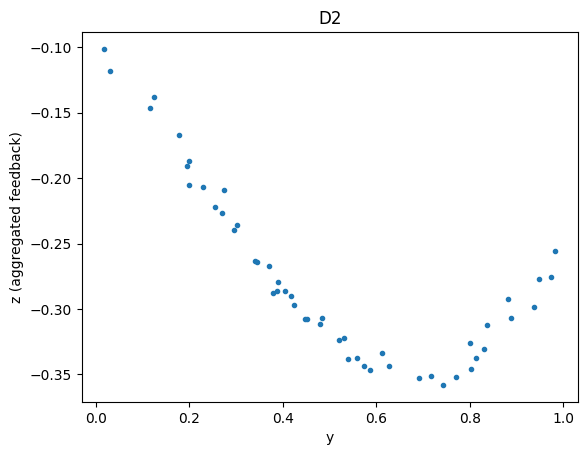

In [8]:
ys2, zs = generate_D2(50, a,b,c,d, l, u, sigma)

In [9]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [10]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp_mz.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [11]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [12]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [13]:
individuals_posterior.sample()

tensor([ 0.0400, -0.0069, -0.0402, -0.0827, -0.1193, -0.1586, -0.1949, -0.2366,
        -0.2751, -0.3033, -0.3443, -0.3744, -0.4091, -0.4433, -0.4746, -0.5041,
        -0.5298, -0.5594, -0.5895, -0.6028, -0.6248, -0.6511, -0.6634, -0.6809,
        -0.7009, -0.7150, -0.7214, -0.7235, -0.7409, -0.7512, -0.7625, -0.7550,
        -0.7641, -0.7578, -0.7524, -0.7531, -0.7502, -0.7400, -0.7268, -0.7167,
        -0.6996, -0.6822, -0.6596, -0.6439, -0.6201, -0.5984, -0.5708, -0.5440,
        -0.5146, -0.4834, -0.4446, -0.4105, -0.3746, -0.3363, -0.2963, -0.2513,
        -0.2087, -0.1646, -0.1188, -0.0666, -0.0164,  0.0296,  0.0817,  0.1377,
         0.1939,  0.2496,  0.3037,  0.3731,  0.4313,  0.4856,  0.5475,  0.6112,
         0.6761,  0.7361,  0.8026,  0.8641,  0.9321,  0.9947,  1.0618,  1.1224,
         1.1956,  1.2604,  1.3249,  1.3908,  1.4659,  1.5265,  1.5945,  1.6638,
         1.7276,  1.7927,  1.8656,  1.9222,  1.9860,  2.0512,  2.1175,  2.1755,
         2.2460,  2.3035,  2.3606,  2.42

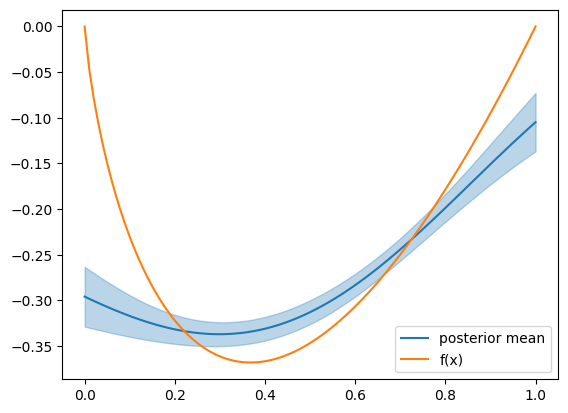

In [14]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [15]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(0.3636)

In [16]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.3030)

In [17]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES

# a = 0.1
# b = 4
# c = 2
# d = 0
# sigma = 0.01

def g_oracle(y, a=0.1,b=4,c=2,d=0, sigma=0.01):
    g_value = g(y, a,b,c,d)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

x_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 5
num_round = 35
num_repeat = 5
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

In [18]:
g_oracle(3)

-0.008782870412576116

In [19]:
agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/pes/',  y_min=-0.35, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
pos_best_dict['pes'] = agent_pes.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mengyan-zhang (oxmlgh). Use `wandb login --relogin` to force relogin


[0.08735789 0.23048249 0.41106284 0.31078648 0.56595456]


Iteration 1: Elapsed Time: 5.740323066711426 seconds


Iteration 2: Elapsed Time: 5.675999164581299 seconds


Iteration 3: Elapsed Time: 5.946759223937988 seconds


Iteration 4: Elapsed Time: 6.134582042694092 seconds


Iteration 5: Elapsed Time: 6.078436851501465 seconds


Iteration 6: Elapsed Time: 6.39050817489624 seconds


Iteration 7: Elapsed Time: 6.150585889816284 seconds


Iteration 8: Elapsed Time: 6.175071954727173 seconds


Iteration 9: Elapsed Time: 6.963220119476318 seconds


Iteration 10: Elapsed Time: 6.6459572315216064 seconds


Iteration 11: Elapsed Time: 6.398148059844971 seconds


Iteration 12: Elapsed Time: 6.953790903091431 seconds


Iteration 13: Elapsed Time: 6.681618928909302 seconds


Iteration 14: Elapsed Time: 6.834223747253418 seconds


Iteration 15: Elapsed Time: 7.006381988525391 seconds


Iteration 16: Elapsed Time: 6.5607359409332275 seconds


Iteration 17: Elapsed Time: 6.8512959480285645 seconds


Iteration 18: Elapsed Time: 7.0366199016571045 seconds


Iteration 19: Elapsed Time: 7.159767150878906 seconds


Iteration 20: Elapsed Time: 6.994768142700195 seconds


Iteration 21: Elapsed Time: 7.199084997177124 seconds


Iteration 22: Elapsed Time: 7.311828136444092 seconds


Iteration 23: Elapsed Time: 7.513175010681152 seconds


Iteration 24: Elapsed Time: 7.619887113571167 seconds


Iteration 25: Elapsed Time: 9.03901219367981 seconds


Iteration 26: Elapsed Time: 9.605562925338745 seconds


Iteration 27: Elapsed Time: 9.618467807769775 seconds


Iteration 28: Elapsed Time: 9.668630599975586 seconds


Iteration 29: Elapsed Time: 9.441927909851074 seconds


100%|██████████| 30/30 [03:38<00:00,  7.30s/it]

Iteration 30: Elapsed Time: 9.900191068649292 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▁▁▁▂▂▂▂▂▃▃▂▃▃▃▃▂▃▃▃▃▄▄▄▄▇███▇█
pos_best,▄▁▁▁▁▁▁▁▁▁▅▅███▇▇▇▄▄▄▄▄▄▄▄▄▃▃▃
regret,▄▁▁▁▁▁▁▁▁▁▅▅███▇▇▇▄▄▄▄▄▄▄▄▄▃▃▃
x_opt,▅█▄▄▆▆▄▅▆▄▁▂▁▂▂▂▁▁▂▁▂▂▂▂▂▂▁▂▂▂
y_rec,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▃▁▁▁▁▁▁▃▁▁▁
z_reward,▇▇▇▆▇▆▆▇▆▇▆▇▇▇▇▇▇▁▇▂▇▇█▇▆▇▃▆▇▆
elapsed_time,9.90019
pos_best,-0.25579
regret,0.11206
x_opt,0.13738
y_rec,1e-05


 20%|██        | 1/5 [03:51<15:27, 231.86s/it]

[0.15416976 0.74004489 0.26331975 0.53373871 0.01458467]


Iteration 1: Elapsed Time: 5.721934080123901 seconds


Iteration 2: Elapsed Time: 5.102856874465942 seconds


Iteration 3: Elapsed Time: 6.039321184158325 seconds


Iteration 4: Elapsed Time: 6.179838180541992 seconds


Iteration 5: Elapsed Time: 6.657674074172974 seconds


Iteration 6: Elapsed Time: 6.404543161392212 seconds


Iteration 7: Elapsed Time: 6.178860664367676 seconds


Iteration 8: Elapsed Time: 6.356945276260376 seconds


Iteration 9: Elapsed Time: 6.59400486946106 seconds


Iteration 10: Elapsed Time: 6.396079063415527 seconds


Iteration 11: Elapsed Time: 6.368780851364136 seconds


Iteration 12: Elapsed Time: 7.007781028747559 seconds


Iteration 13: Elapsed Time: 7.059701204299927 seconds


Iteration 14: Elapsed Time: 6.881935119628906 seconds


Iteration 15: Elapsed Time: 6.710917949676514 seconds


Iteration 16: Elapsed Time: 6.8251307010650635 seconds


Iteration 17: Elapsed Time: 6.81846809387207 seconds


Iteration 18: Elapsed Time: 6.951793909072876 seconds


Iteration 19: Elapsed Time: 6.866315126419067 seconds


Iteration 20: Elapsed Time: 7.0499279499053955 seconds


Iteration 21: Elapsed Time: 7.00394868850708 seconds


Iteration 22: Elapsed Time: 6.958313941955566 seconds


Iteration 23: Elapsed Time: 7.318779945373535 seconds


Iteration 24: Elapsed Time: 7.060994863510132 seconds


Iteration 25: Elapsed Time: 9.182593822479248 seconds


Iteration 26: Elapsed Time: 9.001079082489014 seconds


Iteration 27: Elapsed Time: 9.120059967041016 seconds


Iteration 28: Elapsed Time: 9.256197929382324 seconds


Iteration 29: Elapsed Time: 8.87457799911499 seconds


100%|██████████| 30/30 [03:33<00:00,  7.12s/it]

Iteration 30: Elapsed Time: 9.224250078201294 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▂▁▃▃▄▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▅▄████▇█
pos_best,▃▁▁▁████████████▇▇▆▆▆▆▆▆▆▆▆▆▆▆
regret,▃▁▁▁████████████▇▇▆▆▆▆▆▆▆▆▆▆▆▆
x_opt,▆█▆▆▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
y_rec,▁▁▁▁▁█▇▁▆▆▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
z_reward,██▇▇▇▁▁▇▄▂█▂█▇▇▇▇▇█▆▇▇▇▇▆▇▆██▆
elapsed_time,9.22425
pos_best,-0.10598
regret,0.26188
x_opt,0.03435
y_rec,1e-05


 40%|████      | 2/5 [07:36<11:22, 227.64s/it]

[0.04605007 0.37024491 0.24232342 0.62847743 0.99010024]


Iteration 1: Elapsed Time: 5.231781005859375 seconds


Iteration 2: Elapsed Time: 5.708380222320557 seconds


Iteration 3: Elapsed Time: 5.905921936035156 seconds


 40%|████      | 2/5 [08:00<12:00, 240.12s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
agent_pes.z_rewards

tensor([-0.3294, -0.3542, -0.2075, -0.3740, -0.2467, -0.1131, -0.0991, -0.3433,
        -0.2164, -0.2330, -0.2241, -0.1918, -0.2234, -0.2135, -0.2114, -0.2256,
        -0.1188, -0.1124, -0.1153, -0.1121, -0.1120, -0.1051, -0.1148, -0.1128,
        -0.1040, -0.1008, -0.1006, -0.1139, -0.1121, -0.1103, -0.1061, -0.1058,
        -0.1072, -0.1049, -0.1093])

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


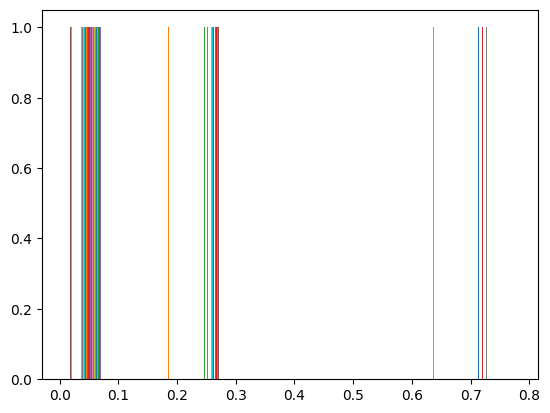

In [ ]:
plt.hist(agent_pes.y_recs)

In [ ]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [ ]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]

[0.83483544 0.10480401 0.74463558 0.36050362 0.35931365]


Iteration 1: Elapsed Time: 3.1421289443969727 seconds


Iteration 2: Elapsed Time: 3.1187939643859863 seconds


Iteration 3: Elapsed Time: 2.970060110092163 seconds


Iteration 4: Elapsed Time: 3.0339620113372803 seconds


Iteration 5: Elapsed Time: 2.995666265487671 seconds


Iteration 6: Elapsed Time: 3.0377211570739746 seconds


Iteration 7: Elapsed Time: 3.30057692527771 seconds


Iteration 8: Elapsed Time: 3.350969076156616 seconds


Iteration 9: Elapsed Time: 3.18027400970459 seconds


Iteration 10: Elapsed Time: 3.2072088718414307 seconds


Iteration 11: Elapsed Time: 2.99058198928833 seconds


Iteration 12: Elapsed Time: 3.1317667961120605 seconds


Iteration 13: Elapsed Time: 3.1280570030212402 seconds


Iteration 14: Elapsed Time: 3.1597800254821777 seconds


Iteration 15: Elapsed Time: 3.2379090785980225 seconds


Iteration 16: Elapsed Time: 3.3565268516540527 seconds


Iteration 17: Elapsed Time: 3.2071280479431152 seconds


Iteration 18: Elapsed Time: 3.164215087890625 seconds


Iteration 19: Elapsed Time: 3.1218979358673096 seconds


Iteration 20: Elapsed Time: 3.793156862258911 seconds


Iteration 21: Elapsed Time: 3.323712110519409 seconds


Iteration 22: Elapsed Time: 3.396766185760498 seconds


Iteration 23: Elapsed Time: 3.1733298301696777 seconds


Iteration 24: Elapsed Time: 3.4453492164611816 seconds


Iteration 25: Elapsed Time: 3.203239917755127 seconds


Iteration 26: Elapsed Time: 3.594783067703247 seconds


Iteration 27: Elapsed Time: 3.4191842079162598 seconds


Iteration 28: Elapsed Time: 3.268937349319458 seconds


Iteration 29: Elapsed Time: 3.3679380416870117 seconds


100%|██████████| 30/30 [01:37<00:00,  3.24s/it]

Iteration 30: Elapsed Time: 3.4477038383483887 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▂▂▁▂▁▂▄▄▃▃▁▂▂▃▃▄▃▃▂█▄▅▃▅▃▆▅▄▄▅
pos_best,███████████▇▇▅▅▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁
y_rec,▁▂▂▅▇▂▂▅▁▂█▇▁▆▆▆▄▁▂▂▄▃▇▃▃▅▅█▁▄
z_reward,▇▆▆▁▂▆▇▁█▇▄▂█▁▁▁▂█▇▇▂▄▂▅▅▂▁▄█▃
elapsed_time,3.4477
pos_best,-0.33911
y_rec,0.49364
z_reward,-0.28065


 20%|██        | 1/5 [01:50<07:20, 110.03s/it]

[0.54585051 0.85884942 0.68588886 0.33159518 0.06000673]


Iteration 1: Elapsed Time: 3.062175989151001 seconds


Iteration 2: Elapsed Time: 3.087315082550049 seconds


Iteration 3: Elapsed Time: 2.97273588180542 seconds


Iteration 4: Elapsed Time: 3.332213878631592 seconds


Iteration 5: Elapsed Time: 3.0567057132720947 seconds


Iteration 6: Elapsed Time: 2.899355173110962 seconds


Iteration 7: Elapsed Time: 3.0025670528411865 seconds


Iteration 8: Elapsed Time: 2.911932945251465 seconds


Iteration 9: Elapsed Time: 3.009766101837158 seconds


Iteration 10: Elapsed Time: 2.9425480365753174 seconds


Iteration 11: Elapsed Time: 2.9804208278656006 seconds


Iteration 12: Elapsed Time: 2.9096200466156006 seconds


Iteration 13: Elapsed Time: 3.0289220809936523 seconds


Iteration 14: Elapsed Time: 2.9210078716278076 seconds


Iteration 15: Elapsed Time: 3.0441880226135254 seconds


Iteration 16: Elapsed Time: 3.029454231262207 seconds


Iteration 17: Elapsed Time: 3.065575361251831 seconds


Iteration 18: Elapsed Time: 2.9397060871124268 seconds


Iteration 19: Elapsed Time: 3.03302001953125 seconds


Iteration 20: Elapsed Time: 3.0563647747039795 seconds


Iteration 21: Elapsed Time: 3.022118330001831 seconds


Iteration 22: Elapsed Time: 2.9374778270721436 seconds


Iteration 23: Elapsed Time: 3.0933837890625 seconds


Iteration 24: Elapsed Time: 3.122283935546875 seconds


Iteration 25: Elapsed Time: 3.0545871257781982 seconds


Iteration 26: Elapsed Time: 2.9682018756866455 seconds


Iteration 27: Elapsed Time: 3.089855194091797 seconds


Iteration 28: Elapsed Time: 3.0473198890686035 seconds


Iteration 29: Elapsed Time: 3.0381410121917725 seconds


100%|██████████| 30/30 [01:30<00:00,  3.02s/it]

Iteration 30: Elapsed Time: 2.989091157913208 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▄▄▂█▄▁▃▁▃▂▂▁▃▁▃▃▄▂▃▄▃▂▄▅▄▂▄▃▃▂
pos_best,▅▅█▄███████████▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁
y_rec,▃▂▁▄█▄▃▅▅▄▃▅▁█▃▃█▁█▄█▆▄▃▇▆▃▁▇▂
z_reward,▄▆█▃▃▂▄▁▁▃▄▂█▄▄▅▃█▃▂▂▁▂▅▁▁▅█▂▆
elapsed_time,2.98909
pos_best,-0.32892
y_rec,0.18768
z_reward,-0.18555


 40%|████      | 2/5 [03:32<05:16, 105.37s/it]

[0.21865067 0.03141209 0.28712953 0.1726512  0.30338031]


Iteration 1: Elapsed Time: 2.993817090988159 seconds


Iteration 2: Elapsed Time: 2.9915268421173096 seconds


Iteration 3: Elapsed Time: 3.0302391052246094 seconds


Iteration 4: Elapsed Time: 3.0261240005493164 seconds


Iteration 5: Elapsed Time: 3.0860981941223145 seconds


Iteration 6: Elapsed Time: 2.9059648513793945 seconds


Iteration 7: Elapsed Time: 3.0549161434173584 seconds


Iteration 8: Elapsed Time: 3.0081069469451904 seconds


Iteration 9: Elapsed Time: 3.051455020904541 seconds


Iteration 10: Elapsed Time: 2.949248790740967 seconds


Iteration 11: Elapsed Time: 2.9070422649383545 seconds


Iteration 12: Elapsed Time: 3.080018997192383 seconds


Iteration 13: Elapsed Time: 3.0446250438690186 seconds


Iteration 14: Elapsed Time: 3.125819206237793 seconds


Iteration 15: Elapsed Time: 3.056821823120117 seconds


Iteration 16: Elapsed Time: 3.0452542304992676 seconds


Iteration 17: Elapsed Time: 3.0317959785461426 seconds


Iteration 18: Elapsed Time: 3.1088461875915527 seconds


Iteration 19: Elapsed Time: 3.047400951385498 seconds


Iteration 20: Elapsed Time: 3.098620891571045 seconds


Iteration 21: Elapsed Time: 3.047821044921875 seconds


Iteration 22: Elapsed Time: 3.0566771030426025 seconds


Iteration 23: Elapsed Time: 2.9879980087280273 seconds


Iteration 24: Elapsed Time: 3.105485200881958 seconds


Iteration 25: Elapsed Time: 3.1023662090301514 seconds


Iteration 26: Elapsed Time: 3.023533821105957 seconds


Iteration 27: Elapsed Time: 3.1289350986480713 seconds


Iteration 28: Elapsed Time: 3.0898711681365967 seconds


Iteration 29: Elapsed Time: 3.0796761512756348 seconds


100%|██████████| 30/30 [01:31<00:00,  3.04s/it]

Iteration 30: Elapsed Time: 2.994666814804077 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▄▄▅▅▇▁▆▄▆▂▁▆▅█▆▅▅▇▅▇▅▆▄▇▇▅█▇▆▄
pos_best,▁▁▁▄███████████████▇▆▆▆▆▆▅▆▄▃▂
y_rec,▅▂▆▇▂▅▄▂▁▂▅▇▃▄▂█▆▁▆▁▁█▄▃▆▃▂▆▅▆
z_reward,▂▆▂▁▇▂▂▆█▇▁▂▄▃▆▂▁█▁▇█▂▄▅▁▄▇▁▂▁
elapsed_time,2.99467
pos_best,-0.29456
y_rec,0.60165
z_reward,-0.3496


 60%|██████    | 3/5 [05:15<03:28, 104.42s/it]

[0.64268705 0.53862015 0.51189774 0.61025501 0.49298912]


Iteration 1: Elapsed Time: 3.03259015083313 seconds


Iteration 2: Elapsed Time: 3.0155587196350098 seconds


Iteration 3: Elapsed Time: 2.9647109508514404 seconds


Iteration 4: Elapsed Time: 3.0113210678100586 seconds


Iteration 5: Elapsed Time: 3.0932390689849854 seconds


Iteration 6: Elapsed Time: 2.914979934692383 seconds


Iteration 7: Elapsed Time: 3.0051519870758057 seconds


Iteration 8: Elapsed Time: 2.9762909412384033 seconds


Iteration 9: Elapsed Time: 3.1191201210021973 seconds


Iteration 10: Elapsed Time: 2.9274837970733643 seconds


Iteration 11: Elapsed Time: 3.013216018676758 seconds


Iteration 12: Elapsed Time: 3.0636959075927734 seconds


Iteration 13: Elapsed Time: 3.1448612213134766 seconds


Iteration 14: Elapsed Time: 2.9874837398529053 seconds


Iteration 15: Elapsed Time: 3.0744340419769287 seconds


Iteration 16: Elapsed Time: 3.079850912094116 seconds


Iteration 17: Elapsed Time: 3.1218740940093994 seconds


Iteration 18: Elapsed Time: 3.070809841156006 seconds


Iteration 19: Elapsed Time: 3.0804851055145264 seconds


Iteration 20: Elapsed Time: 2.994438886642456 seconds


Iteration 21: Elapsed Time: 3.0878310203552246 seconds


Iteration 22: Elapsed Time: 2.9815967082977295 seconds


Iteration 23: Elapsed Time: 3.3056650161743164 seconds


Iteration 24: Elapsed Time: 3.218069076538086 seconds


Iteration 25: Elapsed Time: 3.1824803352355957 seconds


Iteration 26: Elapsed Time: 2.979069948196411 seconds


Iteration 27: Elapsed Time: 3.1322479248046875 seconds


Iteration 28: Elapsed Time: 3.01567006111145 seconds


Iteration 29: Elapsed Time: 3.0786969661712646 seconds


100%|██████████| 30/30 [01:31<00:00,  3.06s/it]

Iteration 30: Elapsed Time: 3.0105648040771484 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▃▃▂▃▄▁▃▂▅▁▃▄▅▂▄▄▅▄▄▂▄▂█▆▆▂▅▃▄▃
pos_best,████▄▂▅▆▆██████▆▆▆▄▄▃▃▃▂▂▂▂▁▁▁
y_rec,▅▃▇▇▃▂▆▅▂▅▄▆▁▃▂▃▅▁▁▆▆▇▅█▆▃▂▇▅█
z_reward,▁▅▃▃▄▆▁▁▆▂▄▁█▄█▄▂██▁▁▂▂▃▁▄▇▂▂▃
elapsed_time,3.01056
pos_best,-0.33424
y_rec,0.9896
z_reward,-0.28139


 80%|████████  | 4/5 [06:56<01:43, 103.25s/it]

[0.78382666 0.634831   0.24904811 0.75807069 0.31308067]


Iteration 1: Elapsed Time: 3.0901060104370117 seconds


Iteration 2: Elapsed Time: 3.002052068710327 seconds


Iteration 3: Elapsed Time: 2.9538111686706543 seconds


Iteration 4: Elapsed Time: 2.9299581050872803 seconds


Iteration 5: Elapsed Time: 3.2015578746795654 seconds


Iteration 6: Elapsed Time: 2.883120059967041 seconds


Iteration 7: Elapsed Time: 2.995002031326294 seconds


Iteration 8: Elapsed Time: 3.0498318672180176 seconds


Iteration 9: Elapsed Time: 3.0287911891937256 seconds


Iteration 10: Elapsed Time: 3.004286050796509 seconds


Iteration 11: Elapsed Time: 2.9444949626922607 seconds


Iteration 12: Elapsed Time: 3.0404300689697266 seconds


Iteration 13: Elapsed Time: 2.9824182987213135 seconds


Iteration 14: Elapsed Time: 3.0063698291778564 seconds


Iteration 15: Elapsed Time: 2.9482967853546143 seconds


Iteration 16: Elapsed Time: 3.0764212608337402 seconds


Iteration 17: Elapsed Time: 3.066720962524414 seconds


Iteration 18: Elapsed Time: 3.0213379859924316 seconds


Iteration 19: Elapsed Time: 3.054659128189087 seconds


Iteration 20: Elapsed Time: 3.0823259353637695 seconds


Iteration 21: Elapsed Time: 3.00602388381958 seconds


Iteration 22: Elapsed Time: 2.9572672843933105 seconds


Iteration 23: Elapsed Time: 3.024440050125122 seconds


Iteration 24: Elapsed Time: 3.02766489982605 seconds


Iteration 25: Elapsed Time: 2.9984090328216553 seconds


Iteration 26: Elapsed Time: 2.9652788639068604 seconds


Iteration 27: Elapsed Time: 3.043531894683838 seconds


Iteration 28: Elapsed Time: 2.9922831058502197 seconds


Iteration 29: Elapsed Time: 3.0088047981262207 seconds


100%|██████████| 30/30 [01:30<00:00,  3.01s/it]

Iteration 30: Elapsed Time: 2.984560966491699 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▆▄▃▂█▁▃▅▄▄▂▄▃▄▂▅▅▄▅▅▄▃▄▄▄▃▅▃▄▃
pos_best,██████████████▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
y_rec,▆▇▇▄▃▁█▄▄▁█▅█▁▂▂▇▂▂▇▇▅▄█▇▆▆▅▃▆
z_reward,▁▂▂▃▅█▄▃▂█▃▂▄█▆▇▂▇▆▂▃▂▂▃▂▁▁▂▄▁
elapsed_time,2.98456
pos_best,-0.32311
y_rec,0.65207
z_reward,-0.35597


100%|██████████| 5/5 [08:37<00:00, 103.50s/it]


<Figure size 640x480 with 0 Axes>

(array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],


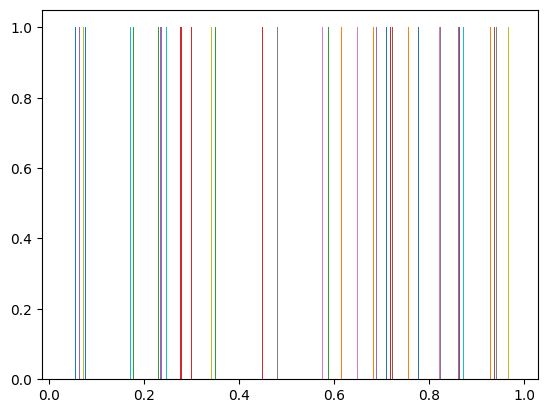

In [ ]:
plt.hist(agent_random.y_recs)

In [ ]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        print(regret_mean)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

[0.2684564  0.1964641  0.10366359 0.23241916 0.23643002 0.30511367
 0.30511367 0.30330408 0.24687414 0.23703408 0.23255321 0.23737986
 0.29905617 0.297535   0.2958295  0.29504532 0.29435304 0.29419622
 0.2942552  0.2604071  0.26023155 0.2604071  0.2604071  0.2604071
 0.2604071  0.2642284  0.2642284  0.2604071  0.2604071  0.2604071 ]
[0.2684564  0.26991856 0.29632494 0.29633614 0.32710284 0.31444368
 0.33760086 0.3519917  0.3519917  0.3677398  0.3677398  0.3584727
 0.3584727  0.34182885 0.3116899  0.24343422 0.22171593 0.2131196
 0.1792197  0.16010821 0.14265478 0.13451473 0.12221937 0.11660651
 0.11114077 0.09675341 0.09862764 0.07463052 0.05947604 0.0438678 ]


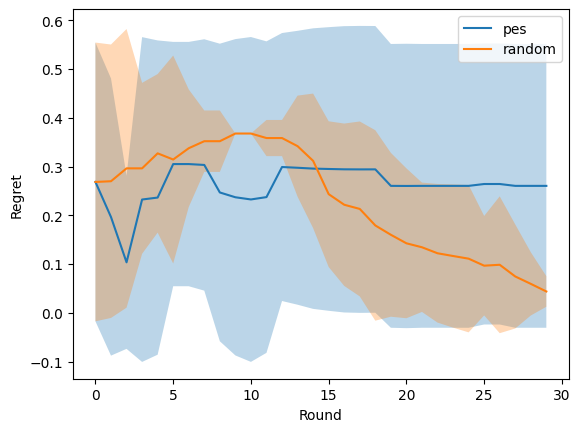

In [ ]:
evalaution(pos_best_dict)

In [ ]:
pos_best_dict['pes'][-1]


[tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.2441),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001)]

In [ ]:
# np.save('pos-seed24.npy', pos_best_dict)